In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import functools


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = io.read_triangle_mesh("../assets/breast_files/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=0, scale=1, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0001, label=4)

kidney_file_dir = "../assets/breast_files/"
kidney_tissue_list = [skin, fat, ligament, gland, gland]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

In [4]:
test_phantom.mask = np.flip(test_phantom.mask, axis=0)
test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
test = test_phantom.get_complete()


In [5]:
print(body_mask.shape)

(258, 361, 227)


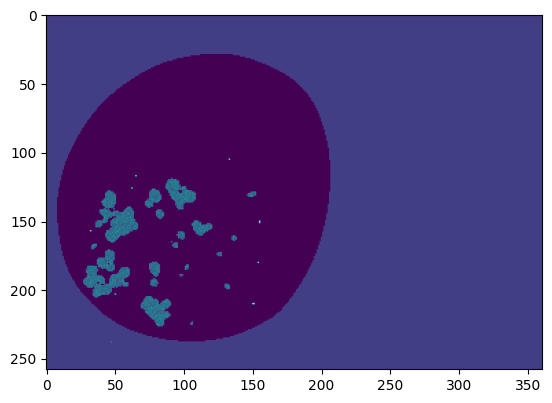

In [6]:
index = 160
plt.imshow(test[0, :, :, index])
bm = np.flip(body_mask, axis=0)
# plt.imshow(bm[:,:, index] * 1000, alpha=0.2, cmap='Reds_r')

In [7]:
test_phantom.save("../assets/breast_files/breast_phantom.h5")

# Set up simulation

In [8]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 40e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [80]:
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[150,150,300], voxel_size[0])
# pt = np.array([pt[2], pt[0], pt[1]])
# normal = -np.array([normal[2], normal[0], normal[1]])

# pose = geometry.Transform.make_from_heading_vector(normal, pt)

# theta = -np.pi/2
# # theta = 0
# about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0,0,0), about_axis=True)

# transducer_pose = about_nl_axis * pose

# test_transducer_set.assign_pose(0, transducer_pose)


In [15]:
transform1 = geometry.Transform([0,0,0], [0,0,0])
transform2 = geometry.Transform([0,np.pi/2-0.3,0], [0,0,0])
transform3 = geometry.Transform([-0.4,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = [-0.05,-0.02,-0.01]
transform.translation = (transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(0, transform)

In [16]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [17]:
np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2

array([ 80.34124905, 140.50000089, 203.12325007])

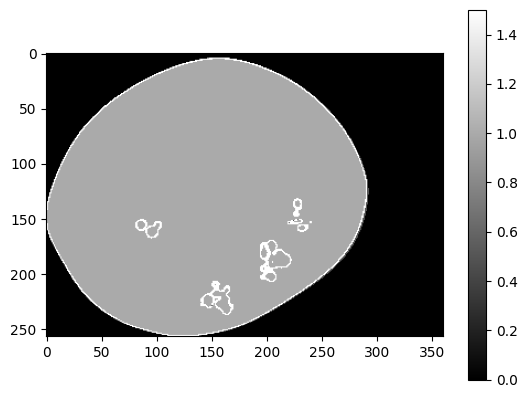

In [18]:
test_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2], body_surface_mask=bm)

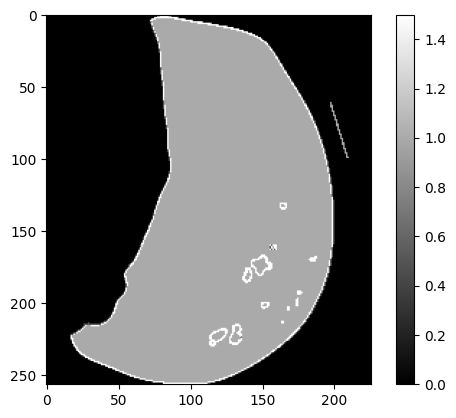

In [19]:
test_sensor.visualize(test_phantom, index=[slice(0, -1, 1), 140, slice(0, -1, 1)], body_surface_mask=bm)

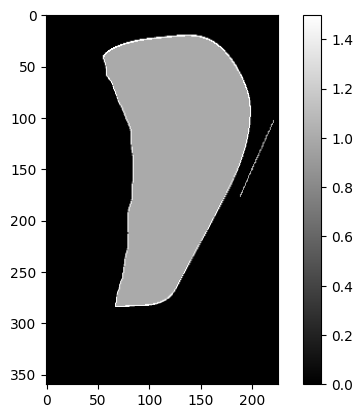

In [20]:
test_sensor.visualize(test_phantom, index=[85, slice(0, -1, 1), slice(0, -1, 1)], body_surface_mask=bm)

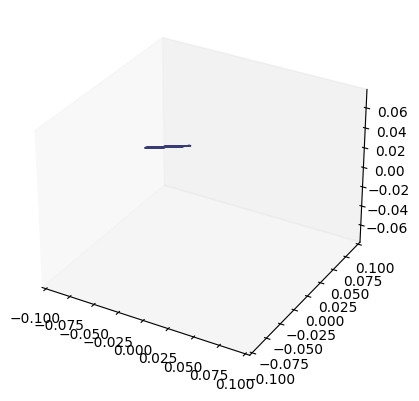

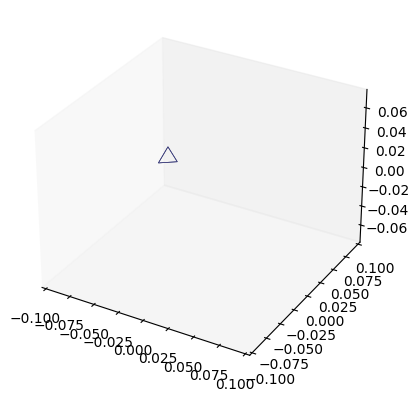

In [21]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [22]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,80e-3,80e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [23]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/breast_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

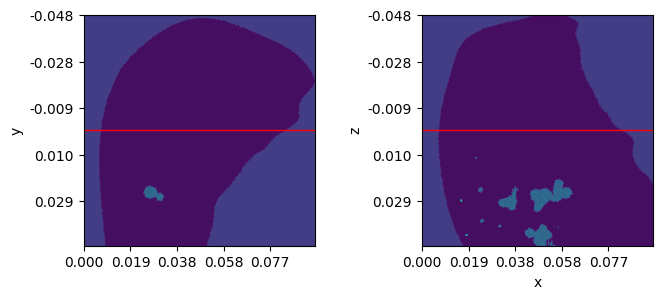

In [24]:
test_experiment.plot_ray_path(31)

# Run Simulation

In [25]:
test_experiment = experiment.Experiment.load('../experiment_files/breast_experiment_01')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (64), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [26]:
test_experiment.run(repeat=True)

running with 3 workers

preparation for sim    0 completed in          139.07 seconds

preparation for sim   32 completed in          147.13 seconds

preparation for sim    1 completed in          185.23 seconds

preparation for sim   33 completed in          197.83 seconds



preparation for sim    2 completed in          177.50 seconds

preparation for sim   34 completed in          175.56 seconds

simulation      0 completed in 607.73 seconds


simulation     32 completed in 426.58 seconds
preparation for sim    3 completed in          174.87 seconds

preparation for sim   35 completed in          193.57 seconds



simulation      1 completed in 545.51 seconds


simulation     33 completed in 426.49 seconds
preparation for sim    4 completed in          193.97 seconds

preparation for sim   36 completed in          200.67 seconds



simulation      2 completed in 557.94 seconds


simulation     34 completed in 428.45 seconds
preparation for sim    5 completed in          187.24 seconds

preparation for sim   37 completed in          196.31 seconds



simulation      3 completed in 551.14 seconds


simulation     35 completed in 430.75 seconds
preparation for sim    6 completed in          186.17 seconds

preparation for sim   38 completed in          198.14 seconds



simulation      4 completed in 550.64 seconds


simulation     36 completed in 430.29 seconds
preparation for sim    7 completed in          184.46 seconds

preparation for sim   39 completed in          197.54 seconds



simulation      5 completed in 550.88 seconds


simulation     37 completed in 431.49 seconds
preparation for sim    8 completed in          177.44 seconds

preparation for sim   40 completed in          188.34 seconds



simulation      6 completed in 535.16 seconds


simulation     38 completed in 432.27 seconds


preparation for sim    9 completed in          153.19 seconds

preparation for sim   41 completed in          165.36 seconds

simulation      7 completed in 465.37 seconds


simulation     39 completed in 431.48 seconds


preparation for sim   10 completed in          145.34 seconds

preparation for sim   42 completed in          152.11 seconds

simulation      8 completed in 433.45 seconds


simulation     40 completed in 430.58 seconds


preparation for sim   11 completed in          144.14 seconds

preparation for sim   43 completed in          154.72 seconds

simulation      9 completed in 435.08 seconds
